# Set logical devices and call Libraries

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau
from keras_segmentation.models.segnet import segnet
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
from PIL import Image
import time
import cv2
from sklearn.metrics import classification_report
from skimage import measure
import PIL
PIL.Image.MAX_IMAGE_PIXELS = 933120000

import GPUtil
import psutil

os.environ["CUDA_VISIBLE_DEVICES"]="0"

GPUtil.showUtilization()
psutil.cpu_percent()



2 Physical GPUs, 2 Logical GPUs
| ID | GPU | MEM |
------------------


2.4

# model training

In [ ]:
data_names = np.sort(glob.glob('net1_data/train_rgb/*'))

start = time.time()

strategy = tf.distribute.MirroredStrategy()

batchsize = 16
with strategy.scope():
    model = segnet(n_classes=2 ,  input_height=416, input_width=608, encoder_level=3 )


print('model.name',model.name)
callbacks = [
    ModelCheckpoint(
                filepath=  "checkpointsnet1/" + model.name + ".{epoch:05d}",
                monitor ='val_loss',
                save_weights_only=True,
                verbose=True
            ),
    EarlyStopping(monitor = 'val_loss',patience=20),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7, verbose=True),
]

def custom_augmentation():
    return  iaa.Sequential(
        [
            iaa.Fliplr(0.5),  # horizontally flip
            iaa.Flipud(0.5), # horizontally flip
        ])

nhist = model.train(
    train_images =  "net1_data/train_rgb/",
    train_annotations = "net1_data/train_anno_reser/",
    validate=True,
    val_images = "net1_data/val_rgb/",
    val_annotations = "net1_data/val_anno_reser/",
    checkpoints_path = "/tmp/net1" ,
    epochs=100,
    batch_size = batchsize,
    steps_per_epoch = int(len(data_names)/batchsize),
    custom_augmentation=custom_augmentation,
    callbacks=callbacks,
    verify_dataset = False
)

print('time:',(time.time() - start)/60)
#*********************************************************


checkpoint_path = "checkpointsnet1/" + model.name + ".{epoch:05d}"
checkpoint_dir = os.path.dirname(checkpoint_path)

latest = tf.train.latest_checkpoint(checkpoint_dir)
#print(latest)

model.load_weights(latest)
#########################################################
#########################################################
#save results :

data = np.sort(glob.glob('net1_data/train_rgb/*'))
print(len(data))
for i in range(len(data)):

    out = model.predict_segmentation(
        inp=data[i],
        out_fname= data[i].replace('net1_data/train_rgb/', 'segnet_output/')
    )

print('train_t is predicted')

data = np.sort(glob.glob('net1_data/val_rgb/*'))
for i in range(len(data)):

    out = model.predict_segmentation(
        inp=data[i],
        out_fname= data[i].replace('net1_data/val_rgb/', 'segnet_output/')
    )

print(len(data))
print('val is predicted')

data = np.sort(glob.glob('net1_data/test_rgb/*'))
for i in range(len(data)):
   # print(data[i], data_label_names[i])
    out = model.predict_segmentation(
        inp=data[i],
        out_fname= data[i].replace('net1_data/test_rgb/', 'segnet_output/')
    )
print(len(data))
print('test is predicted')
#*********************************#*********************************#*********************************
#*********************************#*********************************#*********************************
#*********************************#*********************************#*********************************

#performance evaluation

labels,pre_patches = [], []

labels =np.sort(glob.glob('net1_data/val_anno_reser/*.png'))
labelsos = np.sort(os.listdir('net1_data/val_anno_reser/'))
for i in range(len(labels)):
    if 'png' in labelsos[i]:
        pre_patches+= glob.glob(('segnet_output/'+labelsos[i]).replace('.png','') +'*.png')

print(len(labels), len(pre_patches))

if True:

    masks_list,pre_l = [], []
    s1,s2 = 416,608
    for i in range(len(labels)):# in labels:
        masks_list.append(np.array(Image.open(labels[i]))[:,:,0])
        pre_l.append(np.floor(np.array(Image.open(pre_patches[i]))[:,:,0]/200))
    masks_np = np.asarray(masks_list)
    pre_np = np.asarray(pre_l)

    y_train = np.asarray(masks_np, dtype=np.float32)
    pre_np = np.asarray(pre_np, dtype=np.float32)

    y_train = y_train.reshape(y_train.shape[0], y_train.shape[1], y_train.shape[2], 1)
    yy = y_train.flatten()
    pre_np = pre_np.reshape(pre_np.shape[0], pre_np.shape[1], pre_np.shape[2], 1)
    pre_np = pre_np.flatten()
    print(pre_np.shape, yy.shape)
    #***************************************
    #***************************************
    print('performance in val dataset')
    print(classification_report(yy, pre_np, labels=[0,1], digits=4))

###############################################

#***********************************************************
#performance in test dataset
labels,pre_patches = [], []

labels =np.sort(glob.glob('net1_data/test_anno_reser/*.png'))
labelsos = np.sort(os.listdir('net1_data/test_anno_reser/'))
for i in range(len(labels)):
    if 'png' in labelsos[i]:
        pre_patches+= glob.glob(('segnet_output/'+labelsos[i]).replace('.png','') +'*.png')

print(len(labels), len(pre_patches))

if True:

    masks_list,pre_l = [], []
    s1,s2 = 416,608
    for i in range(len(labels)):# in labels:
        masks_list.append(np.array(Image.open(labels[i]))[:,:,0])
        pre_l.append(np.floor(np.array(Image.open(pre_patches[i]))[:,:,0]/200))
    masks_np = np.asarray(masks_list)
    pre_np = np.asarray(pre_l)

    y_train = np.asarray(masks_np, dtype=np.float32)
    pre_np = np.asarray(pre_np, dtype=np.float32)

    y_train = y_train.reshape(y_train.shape[0], y_train.shape[1], y_train.shape[2], 1)
    yy = y_train.flatten()
    pre_np = pre_np.reshape(pre_np.shape[0], pre_np.shape[1], pre_np.shape[2], 1)
    pre_np = pre_np.flatten()
    print(pre_np.shape, yy.shape)

    print('performance in test dataset')
    print(classification_report(yy, pre_np, labels=[0,1], digits=4))

##############################################

labels,pre_patches = [], []

labels =np.sort(glob.glob('net1_data/train_anno_reser/*.png'))
labelsos = np.sort(os.listdir('net1_data/train_anno_reser/'))
for i in range(len(labels)):
    if 'png' in labelsos[i]:
        pre_patches+= glob.glob(('segnet_output/'+labelsos[i]).replace('.png','') +'*.png')

print(len(labels), len(pre_patches))

if True:

    masks_list,pre_l = [], []
    s1,s2 = 416,608
    for i in range(len(labels)):# in labels:
        masks_list.append(np.array(Image.open(labels[i]))[:,:,0])
        pre_l.append(np.floor(np.array(Image.open(pre_patches[i]))[:,:,0]/200))
    masks_np = np.asarray(masks_list)
    pre_np = np.asarray(pre_l)

    y_train = np.asarray(masks_np, dtype=np.float32)
    pre_np = np.asarray(pre_np, dtype=np.float32)

    y_train = y_train.reshape(y_train.shape[0], y_train.shape[1], y_train.shape[2], 1)
    yy = y_train.flatten()
    pre_np = pre_np.reshape(pre_np.shape[0], pre_np.shape[1], pre_np.shape[2], 1)
    pre_np = pre_np.flatten()
    print(pre_np.shape, yy.shape)
    #***************************************
    #***************************************
    print('performance in train dataset:')
    print(classification_report(yy, pre_np, labels=[0,1], digits=4))

#***********************************

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/

# mosaic prediction outputs

reservoir  ('guarapiranga_2019', (15840, 10935))
number of patches:  449
mosaiced img is saved!


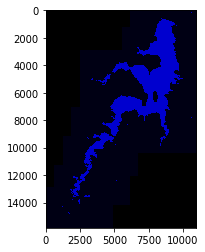

reservoir  ('guarapiranga_2009', (15830, 10935))
number of patches:  448
mosaiced img is saved!


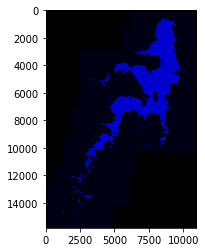

reservoir  ('anta_2014', (11687, 14430))
number of patches:  335
mosaiced img is saved!


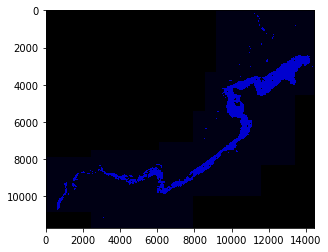

reservoir  ('anta_2020', (11704, 14429))
number of patches:  336
mosaiced img is saved!


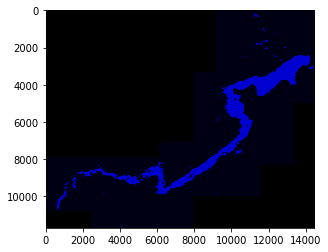

reservoir  ('billings_2009', (17659, 20082))
number of patches:  876
mosaiced img is saved!


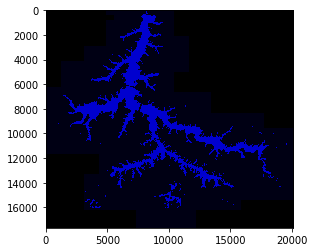

reservoir  ('billings_2019', (17244, 20612))
number of patches:  893
mosaiced img is saved!


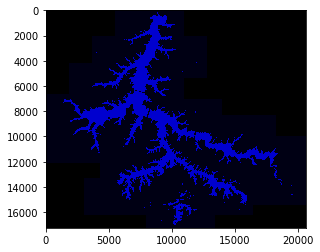

reservoir  ('dona_2011', (20584, 13125))
number of patches:  545
mosaiced img is saved!


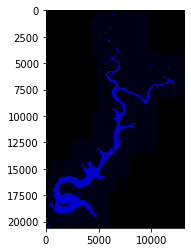

reservoir  ('dona_2017', (20614, 13151))
number of patches:  545
mosaiced img is saved!


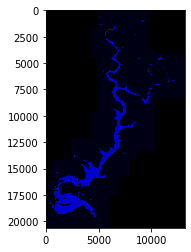

reservoir  ('jaguara_2010', (13664, 17419))
number of patches:  418
mosaiced img is saved!


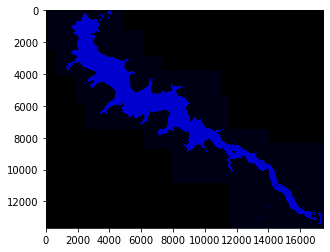

reservoir  ('jaguara_2020', (13704, 17457))
number of patches:  418
mosaiced img is saved!


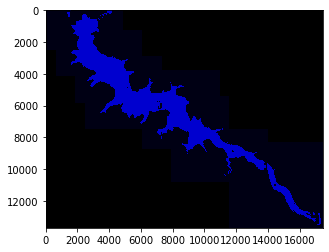

reservoir  ('luiz_2010', (15894, 13887))
number of patches:  583
mosaiced img is saved!


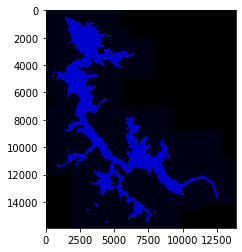

reservoir  ('luiz_2020', (15960, 14858))
number of patches:  594
mosaiced img is saved!


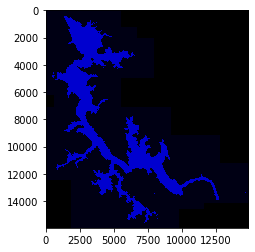

reservoir  ('nov_2010', (24890, 23228))
number of patches:  1038
mosaiced img is saved!


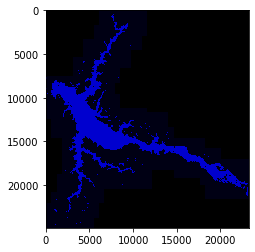

reservoir  ('nov_2021', (24830, 23193))
number of patches:  1026
mosaiced img is saved!


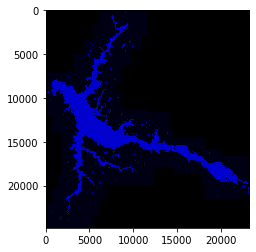

reservoir  ('salto_2005', (12692, 26160))
number of patches:  765
mosaiced img is saved!


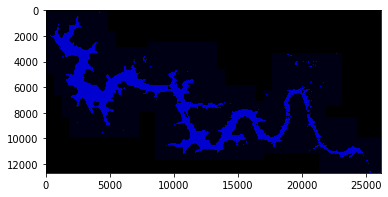

reservoir  ('salto_2020', (12685, 26130))
number of patches:  755
mosaiced img is saved!


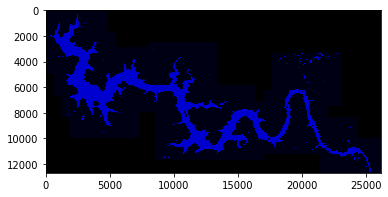

In [ ]:
# reservoir name and size of reservoir mosaiced image
reservoirs =[('guarapiranga_2019',(15840,10935)),('guarapiranga_2009',(15830 ,10935)),('anta_2014',(11687,14430)),
                  ('anta_2020',(11704,14429)),('billings_2009',(17659,20082)),('billings_2019',(17244,20612)),('dona_2011',(20584,13125)),
                  ('dona_2017',(20614,13151)),('jaguara_2010',(13664,17419)),('jaguara_2020',(13704,17457)),('luiz_2010',(15894,13887)),
                  ('luiz_2020',(15960,14858)),('nov_2010',(24890,23228)),('nov_2021',(24830,23193)),('salto_2005',(12692,26160)),('salto_2020',(12685,26130))]

# patch size
patchx , patchy = 416,608
prename= '_segnet_pre.png'# segnet_predict
prediction_mosaicedimg = []

for mosaic_n in range(len(reservoirs)):


    print('reservoir ', reservoirs[mosaic_n])
    patches= np.sort(glob.glob('segnet_output/'+reservoirs[mosaic_n][0]+'*.png'))
    print('number of patches: ',len(patches))
    mosaic = np.zeros((reservoirs[mosaic_n][1][0],reservoirs[mosaic_n][1][1],3) ).astype('uint8')
    for patch_name in patches :
        if True:
            patch_img = cv2.imread(patch_name)

            numbers = []
            for word in patch_name.split():
                if word. isdigit():
                    numbers. append(int(word))

            line, col = numbers[0], numbers[1]

            y0, y1 = (col-1)*patchy, col*patchy
            if y1 > reservoirs[mosaic_n][1][1] :
                y0, y1 = reservoirs[mosaic_n][1][1]-patchy, reservoirs[mosaic_n][1][1]

            x0,x1 = (line-1)*patchx, line*patchx
            if x1 > reservoirs[mosaic_n][1][0] :
                x0, x1 = reservoirs[mosaic_n][1][0]-patchx, reservoirs[mosaic_n][1][0]

            mosaic[x0:x1 , y0:y1, 2 ] = patch_img[:,:,2]

    name = reservoirs[mosaic_n][0] + prename
    cv2.imwrite(name, mosaic)
    print('mosaiced img is saved!')
    plt.imshow(mosaic)
    plt.show()


# postprocessing

In [ ]:
def find_reser_aeras(im):
  #  im[np.isnan(im)] = 0
    labels = measure.label(im, connectivity=1)
    props = measure.regionprops(labels)
    area = [prop.area for prop in props]
    print('number of areas',len(area))
    return area,labels


def delete_holes(im,area,labels,threshold):
    smallclouds = [t[0] for t in filter(lambda a: a[1] < threshold, enumerate(area, 1))]
    for label in smallclouds:
        im[labels == label] = 1

    return im

def delete_water_bodies(im,area,labels,threshold):
    smallclouds = [t[0] for t in filter(lambda a: a[1] < threshold, enumerate(area, 1))]
    for label in smallclouds:
        im[labels == label] = 0
    return im

def find_patches(output,labels,reservoir):
    refine_patches = []
    #output = cm_maxvot[mosaic_n]
    #print('output.shape', output.shape)
    for patch_name in labels :


        numbers = []
        for word in patch_name.split():
            if word. isdigit():
                numbers. append(int(word))

        line, col = numbers[0], numbers[1]

        y0, y1 = (col-1)*patchy, col*patchy
        if y1 > reservoir[1][1] :
            y0, y1 = reservoir[1][1]-patchy, reservoir[1][1]

        x0,x1 = (line-1)*patchx, line*patchx
        if x1 > reservoir[1][0] :
            x0, x1 = reservoir[1][0]-patchx, reservoir[1][0]

        refine_patches.append(output[x0:x1 , y0:y1])
    return refine_patches





guarapiranga_2019
img : 


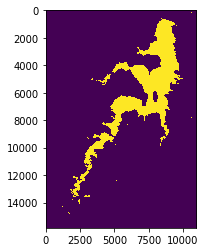

closing100


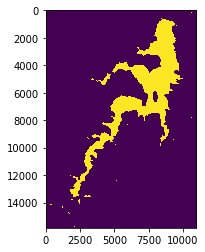

opening100


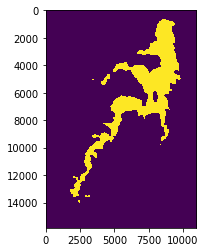

**********************************************
number of areas 8
refined_1
1


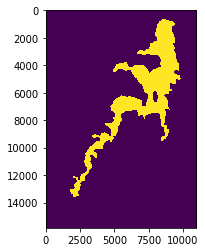

number of areas 3
wo hoçes


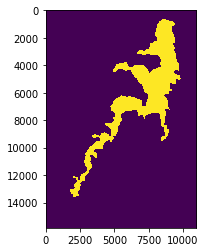

**********************************************
len(labels) 449
1.0 1
              precision    recall  f1-score   support

           0     0.9900    0.9914    0.9907  93910429
           1     0.9586    0.9523    0.9554  19654243

    accuracy                         0.9846 113564672
   macro avg     0.9743    0.9718    0.9731 113564672
weighted avg     0.9846    0.9846    0.9846 113564672

refinment: 
1 0
              precision    recall  f1-score   support

           0     0.9908    0.9900    0.9904  93910429
           1     0.9524    0.9562    0.9543  19654243

    accuracy                         0.9842 113564672
   macro avg     0.9716    0.9731    0.9724 113564672
weighted avg     0.9842    0.9842    0.9842 113564672

**********************************************************
guarapiranga_2009
img : 


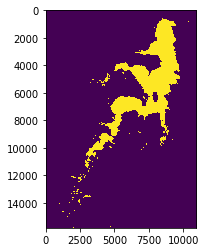

closing100


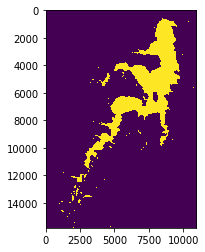

opening100


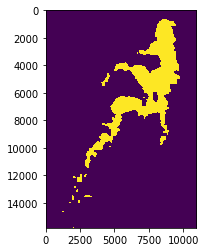

**********************************************
number of areas 17
refined_1
1


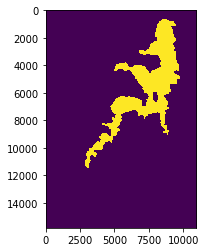

number of areas 3
wo hoçes


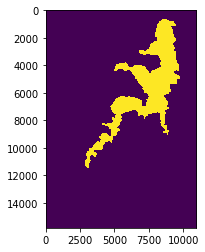

**********************************************
len(labels) 448
1.0 1
              precision    recall  f1-score   support

           0     0.9892    0.9827    0.9859  95310037
           1     0.9115    0.9431    0.9270  18001707

    accuracy                         0.9764 113311744
   macro avg     0.9503    0.9629    0.9565 113311744
weighted avg     0.9768    0.9764    0.9766 113311744

refinment: 
1 0
              precision    recall  f1-score   support

           0     0.9940    0.9902    0.9921  95310037
           1     0.9492    0.9686    0.9588  18001707

    accuracy                         0.9868 113311744
   macro avg     0.9716    0.9794    0.9755 113311744
weighted avg     0.9869    0.9868    0.9868 113311744

**********************************************************
anta_2014
img : 


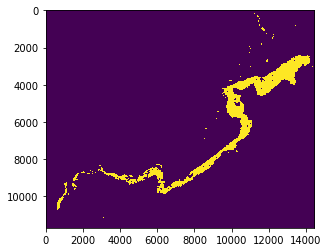

closing100


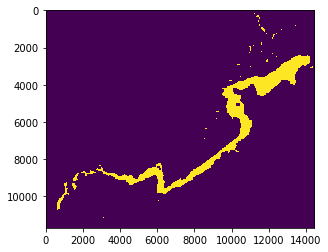

opening100


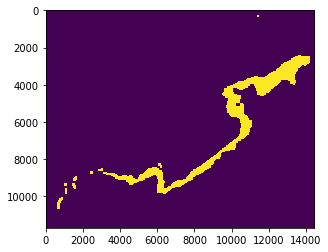

**********************************************
number of areas 10
refined_1
1


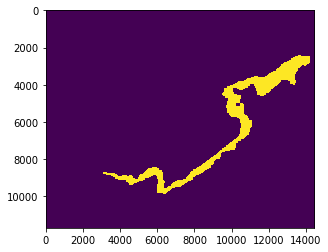

number of areas 3
wo hoçes


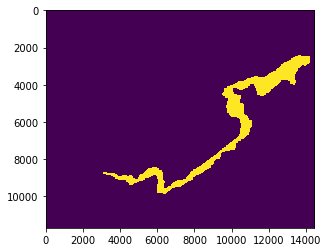

**********************************************
len(labels) 335
1.0 1
              precision    recall  f1-score   support

           0     0.9845    0.9895    0.9869  76471393
           1     0.8975    0.8553    0.8759   8259487

    accuracy                         0.9764  84730880
   macro avg     0.9410    0.9224    0.9314  84730880
weighted avg     0.9760    0.9764    0.9761  84730880

refinment: 
1 0
              precision    recall  f1-score   support

           0     0.9915    0.9956    0.9935  76471393
           1     0.9572    0.9207    0.9386   8259487

    accuracy                         0.9883  84730880
   macro avg     0.9743    0.9581    0.9661  84730880
weighted avg     0.9881    0.9883    0.9882  84730880

**********************************************************
anta_2020
img : 


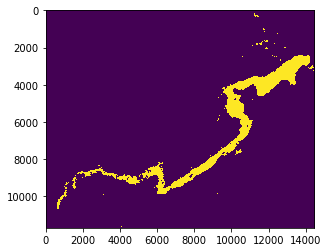

closing100


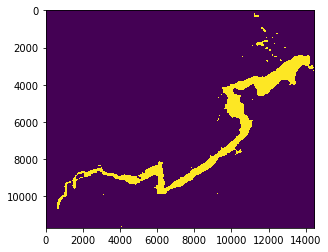

opening100


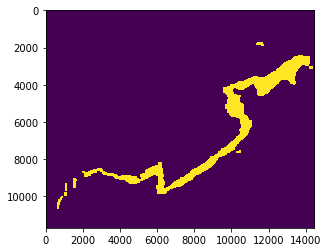

**********************************************
number of areas 7
refined_1
1


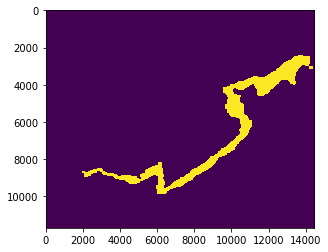

number of areas 2
wo hoçes


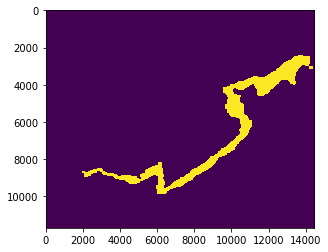

**********************************************
len(labels) 336
1.0 1
              precision    recall  f1-score   support

           0     0.9880    0.9920    0.9900  75875245
           1     0.9308    0.8995    0.9149   9108563

    accuracy                         0.9821  84983808
   macro avg     0.9594    0.9458    0.9525  84983808
weighted avg     0.9819    0.9821    0.9819  84983808

refinment: 
1 0
              precision    recall  f1-score   support

           0     0.9932    0.9970    0.9951  75875245
           1     0.9742    0.9429    0.9583   9108563

    accuracy                         0.9912  84983808
   macro avg     0.9837    0.9700    0.9767  84983808
weighted avg     0.9911    0.9912    0.9911  84983808

**********************************************************
billings_2009
img : 


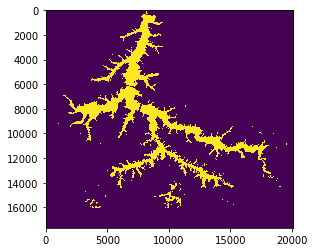

closing100


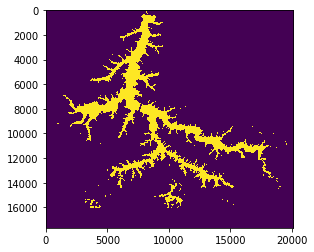

opening100


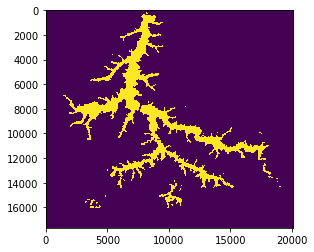

**********************************************
number of areas 47
refined_1
1


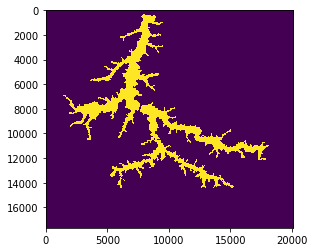

number of areas 4
wo hoçes


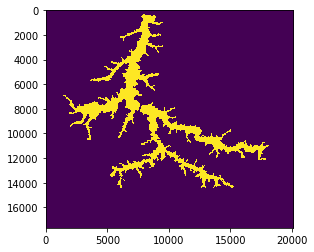

**********************************************
len(labels) 876
1.0 1
              precision    recall  f1-score   support

           0     0.9868    0.9880    0.9874 187646679
           1     0.9330    0.9267    0.9299  33918249

    accuracy                         0.9786 221564928
   macro avg     0.9599    0.9573    0.9586 221564928
weighted avg     0.9785    0.9786    0.9786 221564928

refinment: 
1 0
              precision    recall  f1-score   support

           0     0.9812    0.9935    0.9873 187646679
           1     0.9613    0.8944    0.9266  33918249

    accuracy                         0.9783 221564928
   macro avg     0.9712    0.9440    0.9570 221564928
weighted avg     0.9781    0.9783    0.9780 221564928

**********************************************************
billings_2019
img : 


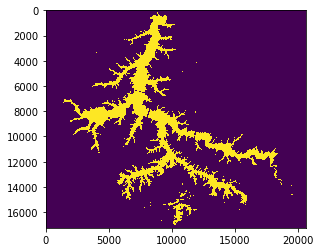

closing100


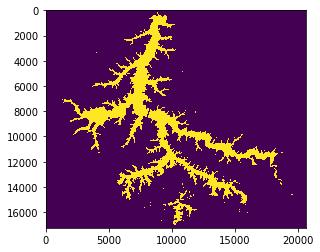

opening100


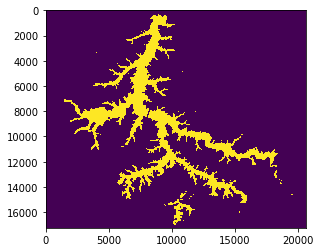

**********************************************
number of areas 38
refined_1
1


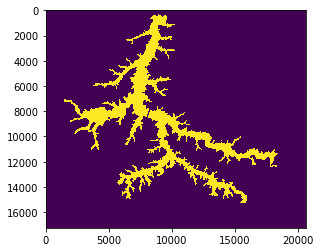

number of areas 5
wo hoçes


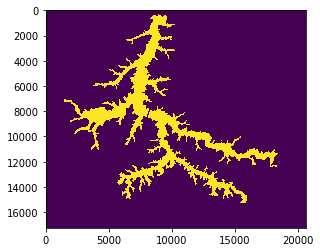

**********************************************
len(labels) 893
1.0 1
              precision    recall  f1-score   support

           0     0.9881    0.9858    0.9869 187129021
           1     0.9321    0.9427    0.9374  38735683

    accuracy                         0.9784 225864704
   macro avg     0.9601    0.9642    0.9622 225864704
weighted avg     0.9785    0.9784    0.9784 225864704

refinment: 
1 0
              precision    recall  f1-score   support

           0     0.9838    0.9922    0.9879 187129021
           1     0.9605    0.9209    0.9403  38735683

    accuracy                         0.9799 225864704
   macro avg     0.9721    0.9565    0.9641 225864704
weighted avg     0.9798    0.9799    0.9798 225864704

**********************************************************
dona_2011
img : 


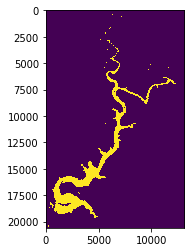

closing100


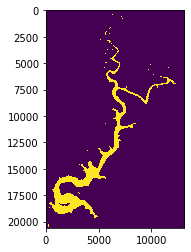

opening100


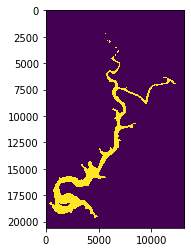

**********************************************
number of areas 8
refined_1
1


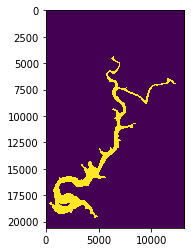

number of areas 3
wo hoçes


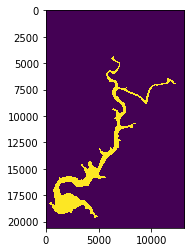

**********************************************
len(labels) 545
1.0 1
              precision    recall  f1-score   support

           0     0.9959    0.9932    0.9945 122544881
           1     0.9467    0.9672    0.9568  15300879

    accuracy                         0.9903 137845760
   macro avg     0.9713    0.9802    0.9757 137845760
weighted avg     0.9904    0.9903    0.9904 137845760

refinment: 
1 0
              precision    recall  f1-score   support

           0     0.9964    0.9941    0.9952 122544881
           1     0.9534    0.9715    0.9623  15300879

    accuracy                         0.9916 137845760
   macro avg     0.9749    0.9828    0.9788 137845760
weighted avg     0.9916    0.9916    0.9916 137845760

**********************************************************
dona_2017
img : 


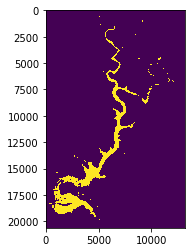

closing100


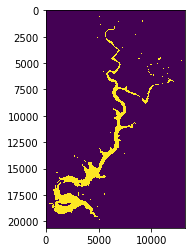

opening100


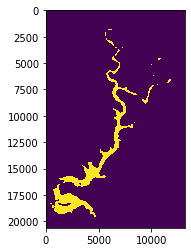

**********************************************
number of areas 17
refined_1
1


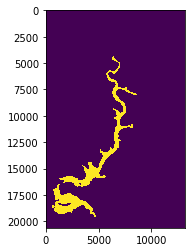

number of areas 5
wo hoçes


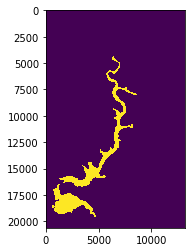

**********************************************
len(labels) 545
1.0 1
              precision    recall  f1-score   support

           0     0.9908    0.9901    0.9905 123486348
           1     0.9157    0.9206    0.9181  14359412

    accuracy                         0.9829 137845760
   macro avg     0.9532    0.9554    0.9543 137845760
weighted avg     0.9829    0.9829    0.9829 137845760

refinment: 
1 0
              precision    recall  f1-score   support

           0     0.9899    0.9959    0.9928 123486348
           1     0.9624    0.9122    0.9366  14359412

    accuracy                         0.9871 137845760
   macro avg     0.9761    0.9540    0.9647 137845760
weighted avg     0.9870    0.9871    0.9870 137845760

**********************************************************
jaguara_2010
img : 


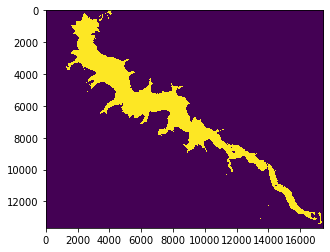

closing100


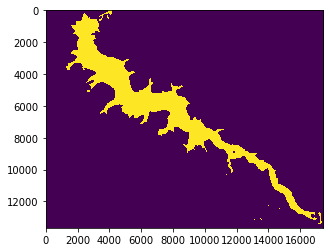

opening100


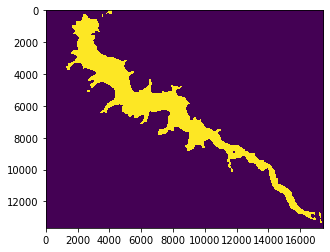

**********************************************
number of areas 7
refined_1
1


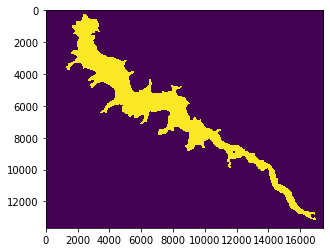

number of areas 3
wo hoçes


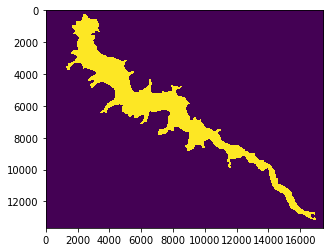

**********************************************
len(labels) 418
1.0 1
              precision    recall  f1-score   support

           0     0.9957    0.9929    0.9943  82939985
           1     0.9744    0.9846    0.9795  22783919

    accuracy                         0.9911 105723904
   macro avg     0.9851    0.9887    0.9869 105723904
weighted avg     0.9911    0.9911    0.9911 105723904

refinment: 
1 0
              precision    recall  f1-score   support

           0     0.9943    0.9936    0.9940  82939985
           1     0.9768    0.9793    0.9780  22783919

    accuracy                         0.9905 105723904
   macro avg     0.9855    0.9864    0.9860 105723904
weighted avg     0.9905    0.9905    0.9905 105723904

**********************************************************
jaguara_2020
img : 


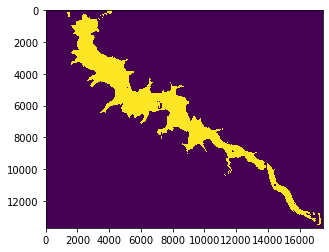

closing100


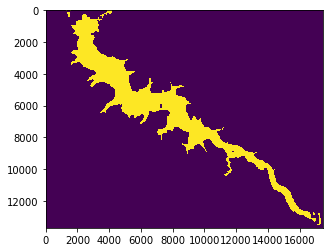

opening100


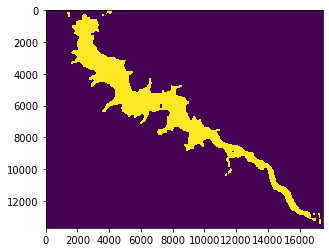

**********************************************
number of areas 10
refined_1
1


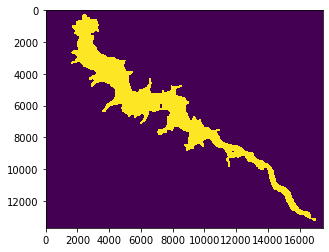

number of areas 4
wo hoçes


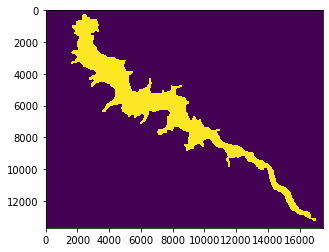

**********************************************
len(labels) 418
1.0 1
              precision    recall  f1-score   support

           0     0.9929    0.9944    0.9937  82939277
           1     0.9796    0.9741    0.9769  22784627

    accuracy                         0.9901 105723904
   macro avg     0.9863    0.9843    0.9853 105723904
weighted avg     0.9900    0.9901    0.9900 105723904

refinment: 
1 0
              precision    recall  f1-score   support

           0     0.9918    0.9956    0.9937  82939277
           1     0.9837    0.9700    0.9768  22784627

    accuracy                         0.9901 105723904
   macro avg     0.9877    0.9828    0.9852 105723904
weighted avg     0.9900    0.9901    0.9900 105723904

**********************************************************
luiz_2010
img : 


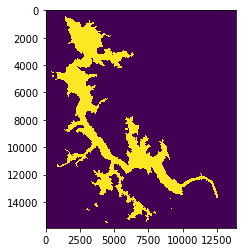

closing100


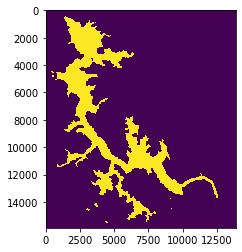

opening100


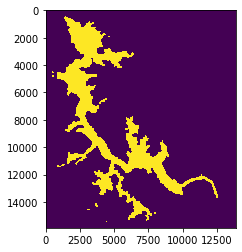

**********************************************
number of areas 11
refined_1
1


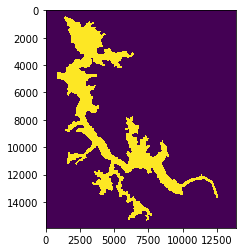

number of areas 2
wo hoçes


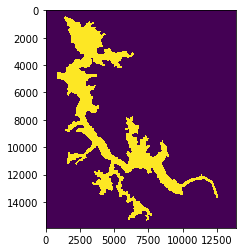

**********************************************
len(labels) 583
1.0 1
              precision    recall  f1-score   support

           0     0.9959    0.9960    0.9959 117435664
           1     0.9843    0.9839    0.9841  30021360

    accuracy                         0.9935 147457024
   macro avg     0.9901    0.9899    0.9900 147457024
weighted avg     0.9935    0.9935    0.9935 147457024

refinment: 
1 0
              precision    recall  f1-score   support

           0     0.9922    0.9939    0.9930 117435664
           1     0.9759    0.9694    0.9726  30021360

    accuracy                         0.9889 147457024
   macro avg     0.9840    0.9816    0.9828 147457024
weighted avg     0.9889    0.9889    0.9889 147457024

**********************************************************
luiz_2020
img : 


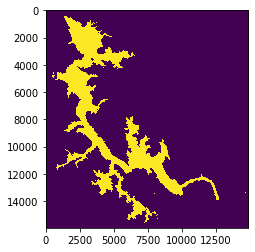

closing100


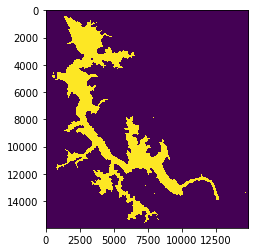

opening100


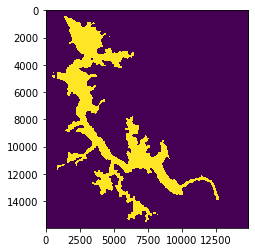

**********************************************
number of areas 9
refined_1
1


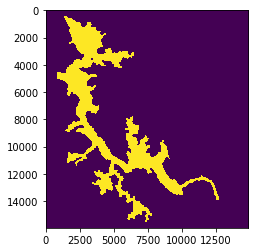

number of areas 3
wo hoçes


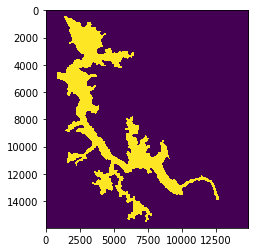

**********************************************
len(labels) 594
1.0 1
              precision    recall  f1-score   support

           0     0.9975    0.9963    0.9969 119726662
           1     0.9857    0.9902    0.9879  30512570

    accuracy                         0.9951 150239232
   macro avg     0.9916    0.9933    0.9924 150239232
weighted avg     0.9951    0.9951    0.9951 150239232

refinment: 
1 0
              precision    recall  f1-score   support

           0     0.9929    0.9932    0.9930 119726662
           1     0.9731    0.9719    0.9725  30512570

    accuracy                         0.9888 150239232
   macro avg     0.9830    0.9825    0.9828 150239232
weighted avg     0.9888    0.9888    0.9888 150239232

**********************************************************
nov_2010
img : 


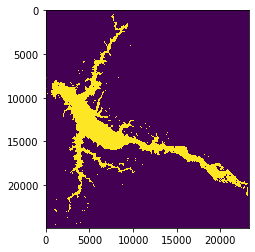

closing100


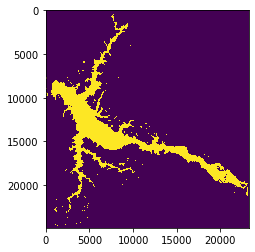

opening100


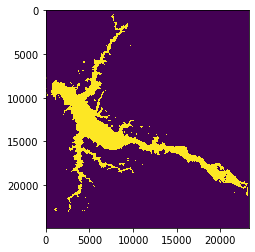

**********************************************
number of areas 57
refined_1
1


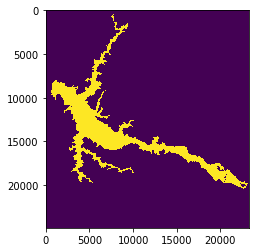

number of areas 14
wo hoçes


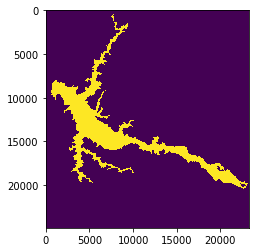

**********************************************
len(labels) 1038
1.0 1
              precision    recall  f1-score   support

           0     0.9838    0.9874    0.9856 206399264
           1     0.9530    0.9404    0.9467  56140000

    accuracy                         0.9773 262539264
   macro avg     0.9684    0.9639    0.9661 262539264
weighted avg     0.9773    0.9773    0.9773 262539264

refinment: 
1 0
              precision    recall  f1-score   support

           0     0.9821    0.9946    0.9883 206399264
           1     0.9792    0.9334    0.9557  56140000

    accuracy                         0.9815 262539264
   macro avg     0.9806    0.9640    0.9720 262539264
weighted avg     0.9815    0.9815    0.9814 262539264

**********************************************************
nov_2021
img : 


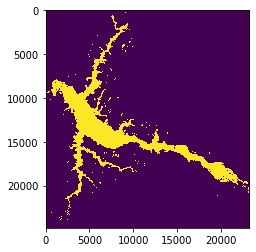

closing100


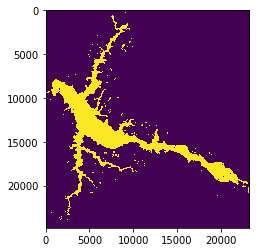

opening100


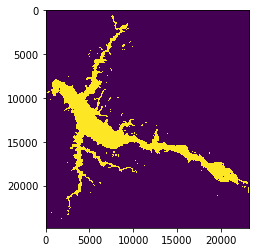

**********************************************
number of areas 89
refined_1
1


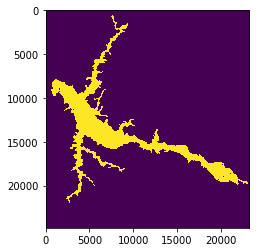

number of areas 9
wo hoçes


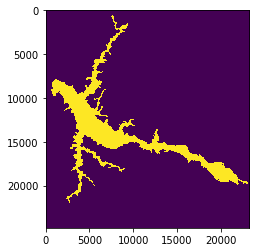

**********************************************
len(labels) 1026
1.0 1
              precision    recall  f1-score   support

           0     0.9833    0.9803    0.9818 205662118
           1     0.9256    0.9365    0.9310  53842010

    accuracy                         0.9712 259504128
   macro avg     0.9544    0.9584    0.9564 259504128
weighted avg     0.9713    0.9712    0.9713 259504128

refinment: 
1 0
              precision    recall  f1-score   support

           0     0.9867    0.9913    0.9890 205662118
           1     0.9663    0.9490    0.9576  53842010

    accuracy                         0.9826 259504128
   macro avg     0.9765    0.9702    0.9733 259504128
weighted avg     0.9825    0.9826    0.9825 259504128

**********************************************************
salto_2005
img : 


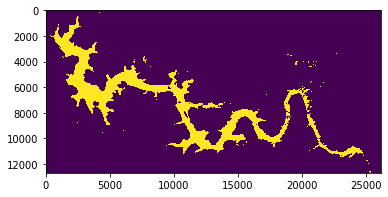

closing100


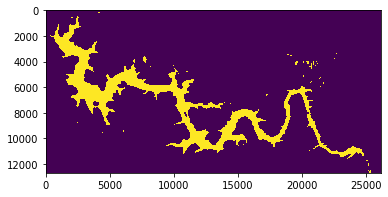

opening100


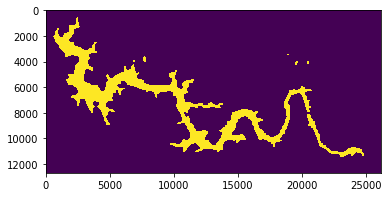

**********************************************
number of areas 8
refined_1
1


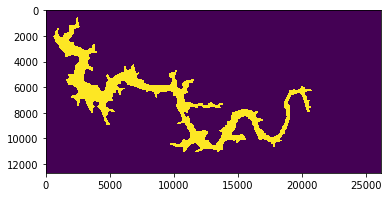

number of areas 2
wo hoçes


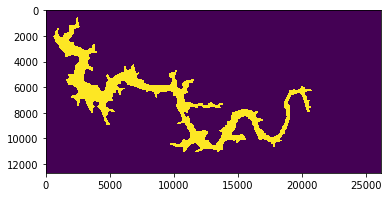

**********************************************
len(labels) 765
1.0 1
              precision    recall  f1-score   support

           0     0.9884    0.9917    0.9900 161353750
           1     0.9575    0.9414    0.9494  32136170

    accuracy                         0.9833 193489920
   macro avg     0.9730    0.9666    0.9697 193489920
weighted avg     0.9833    0.9833    0.9833 193489920

refinment: 
1 0
              precision    recall  f1-score   support

           0     0.9796    0.9944    0.9869 161353750
           1     0.9697    0.8959    0.9313  32136170

    accuracy                         0.9781 193489920
   macro avg     0.9746    0.9451    0.9591 193489920
weighted avg     0.9779    0.9781    0.9777 193489920

**********************************************************
salto_2020
img : 


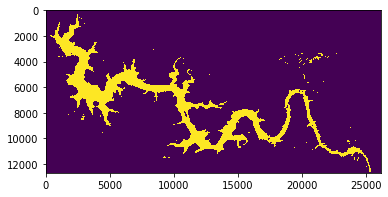

closing100


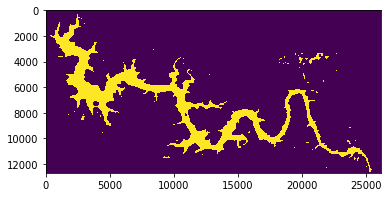

opening100


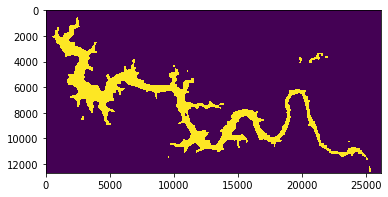

**********************************************
number of areas 14
refined_1
1


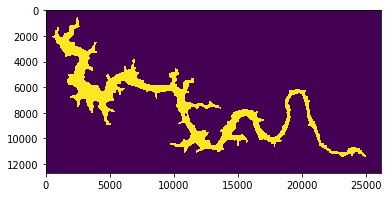

number of areas 3
wo hoçes


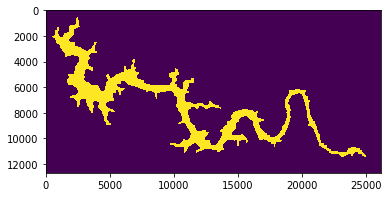

**********************************************
len(labels) 755
1.0 1
              precision    recall  f1-score   support

           0     0.9955    0.9884    0.9920 158860187
           1     0.9447    0.9781    0.9611  32100453

    accuracy                         0.9867 190960640
   macro avg     0.9701    0.9833    0.9765 190960640
weighted avg     0.9870    0.9867    0.9868 190960640

refinment: 
1 0
              precision    recall  f1-score   support

           0     0.9943    0.9956    0.9950 158860187
           1     0.9780    0.9718    0.9749  32100453

    accuracy                         0.9916 190960640
   macro avg     0.9862    0.9837    0.9849 190960640
weighted avg     0.9916    0.9916    0.9916 190960640

**********************************************************


In [ ]:
# resolution of images of reservoirs
resolutions = [1.2,0.95,1.7,1.2,1.2,1.2,1.7,0.95]

morpho, morpho200 = [], []
all_pres, all_refine, all_anno = [],[],[]
for i in range(len(reservoirs)):
    print(reservoirs[i][0])
    k = int(100/resolutions[int(i/2)])
    kernel = np.ones((k,k),np.uint8)

    img = cv2.imread(reservoirs[i][0]+'_segnet_pre.png')[:,:,2]
    maximg = np.max(img)
    img = np.floor(img/190)

    print('img : ')
    plt.imshow(img)
    plt.show()

    closing = cv2.morphologyEx(img , cv2.MORPH_CLOSE, kernel)
    print('closing100')
    plt.imshow(closing)
    plt.show()

    opening = cv2.morphologyEx(closing , cv2.MORPH_OPEN, kernel)
    print('opening100')
    plt.imshow(opening)
    plt.show()


    newimg = np.zeros((img.shape[0],img.shape[1],3))
    newimg[:,:,2] = opening[:,:]*100# opening[:,:]*100
    morpho.append(newimg)


    print('**********************************************')

    input_img = np.floor(newimg[:,:,2]/90).astype(int)

    mosaic_wo_small_res = input_img


    area,labels = find_reser_aeras(mosaic_wo_small_res)
    max_area, min_area = max(area),min(area)
    threshold= int(max_area/10)
    refined_1 = delete_water_bodies(mosaic_wo_small_res,area,labels,threshold)
    print('refined_1')

    print(np.max(refined_1))
    plt.imshow(refined_1*100)
    plt.show()

    #********** holes :
    input_img = refined_1
    area,labels = find_reser_aeras(input_img+1)
    max_area, min_area = max(area),min(area)

    threshold= int(max_area/10)
    refined_2 = delete_holes(input_img,area,labels,threshold)


    print('wo hoçes')
    plt.imshow(refined_2*100)
    plt.show()

    print('**********************************************')

#'**********************************************'
#'**********************************************'
#'********************************************** performance evaluation before and after post-processing: *************************


    labels = np.sort(glob.glob('net1_data/test_anno_reser/'+reservoirs[i][0]+'*')+glob.glob('net1_data/val_anno_reser/'+reservoirs[i][0]+'*')+glob.glob('net1_data/train_anno_reser/'+reservoirs[i][0]+'*'))
    print('len(labels)',len(labels))
    masks_list = []
    for ii in range(len(labels)):
        masks_list.append(cv2.imread(labels[ii])[:,:,0])
        all_anno.append(cv2.imread(labels[ii])[:,:,0])

    masks_np = np.asarray(masks_list)
    yy = masks_np.flatten()

    pres =[]
    for ii in range(len(labels)):
        if 'test' in labels[ii]:
            n = labels[ii].replace('net1_data/test_anno_reser/','segnet_output/')
        elif 'val' in labels[ii]:
            n = labels[ii].replace('net1_data/val_anno_reser/','segnet_output/')
        elif 'train' in labels[ii]:
            n = labels[ii].replace('net1_data/train_anno_reser/','segnet_output/')
        pres.append(np.floor(cv2.imread(n)[:,:,2]/190))
        all_pres.append(np.floor(cv2.imread(n)[:,:,2]/190))

    preds = np.array(pres).flatten()
    print(np.max(preds), np.max(yy))
    print(classification_report(yy, preds, labels=[0,1], digits=4))

    print('refinment: ')
    output = refined_2

    print(np.max(output), np.min(output))
    refine_patches = find_patches(output,labels,reservoirs[i])
    refine = np.array(refine_patches).flatten()
    all_refine.append(refine)
    print(classification_report(yy, refine, labels=[0,1], digits=4))
    print('**********************************************************')